# Assignment 03

**Citation:** The following questions and supporting code were originally developed as part of Dr. Eric Eaton's [Introduction to Machine Learning Course at U Penn](https://www.cis.upenn.edu/~cis5190/fall2014/). 

In [1]:
from typing import Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np

# LASSO On a Real Dataset

Given $\lambda > 0$ and data $(x_i, y_i)_{i=1}^{n}$, the Lasso is the problem of solving

\begin{equation}
\arg\min_{w \in \mathbb{R}^{d},b\in\mathbb{R}} \sum_{i=1}^{n}(x_{i}^{T}w + b - y_{i})^{2} + \lambda \sum_{j=1}^{d}|w_j| \tag{1}
\end{equation}

where $\lambda$ is a regularization parameter. For the programming part of this homework, you will implement thecoordinate descent method shown in Algorithm 1 to solve the Lasso problem. You may use common computing packages (such as ```numpy``` or ```scipy```), but do not use an existing Lasso solver (e.g., of ```scikit-learn```).


***
**Algorithm 1:** Coordinate Descent Algorithm for LASSO
***
1.&emsp;**while** not converged **do**

2.&emsp;&emsp; $b \gets \frac{1}{n}\sum_{i=1}^{n}(y_{i}-\sum_{j=1}^{d} w_{j}x_{i,j})$

3.&emsp;&emsp;**for** $k\in \{1,\ldots,d\}$ **do**

4.&emsp;&emsp;&emsp; $a_{k} \gets 2\sum_{i=1}^{n}x_{i,k}^{2}$

5.&emsp;&emsp;&emsp; $c_{k} \gets 2\sum_{i=1}^{n}x_{i,k}(y_{i}-(b + \sum_{j\neq k}w_{j}x_{i,j}))$

6.&emsp;&emsp;&emsp; $w_{k} \gets \begin{cases}
(c_{k} + \lambda)/a_{k} & c_{k} < -\lambda\\
0 & c_{k} \in [-\lambda,\lambda]\\
(c_{k} - \lambda)/a_{k} & c_{k} > \\lambda\\
\end{cases}$


7.&emsp;&emsp;**end** **for**

8.&emsp;**end** **while**
***

Before you get started, the following hints may be useful:
- Wherever possible, use matrix libraries for matrix operations (not ```for``` loops).
- There are opportunities to considerably speed up parts of the algorithm by precomputing quantities like $a_{k}$ before the for loop; you are permitted to add these improvements (and it may save you some time).
- As a sanity check, ensure the objective value is nonincreasing with each step.
- It is up to you to decide on a suitable stopping condition. A common criteria is to stop when no element of $w$ changes by more than some small $\delta$ during an iteration. If you need your algorithm to run faster, an easy place to start is to loosen this condition.
- You will need to solve the Lasso on the same dataset for many values of $\lambda$. This is called a regularization path. One way to do this efficiently is to start at a large $\lambda$, and then for each consecutive solution, initialize the algorithm with the previous solution, decreasing $\lambda$ by a constant ratio (e.g., by a factor of 2).
- The smallest value of $\lambda$ for which the solution $\hat{w}$ is entirely zero is given by
\begin{equation}
\lambda_\mathrm{max} = \max_{k=1,\ldots,d}2\left|\sum_{i=1}^{n}x_{i,k}\left(y_{i}-\left(\frac{1}{n}\sum_{j=1}^{n}y_{j}\right)\right)\right| \tag{2}
\end{equation} 
This is helpful for choosing the first $\lambda$ in a regularization path.


## Q1 - Lasso on Synthetic Data 

We will first try out your solver with some synthetic data. A benefit of the Lasso is that if we believe many features are irrelevant for predicting $y$, the Lasso can be used to enforce a sparse solution, effectively differentiating between the relevant and irrelevant features. Suppose that $x \in \mathbb{R}^{d}$, $y \in \mathbb{R}$, $k < d$, and data are generated independently according to the model $y_{i} = w^{T}x_{i} + \epsilon_{i}$ where
$$
w_{j} = \begin{cases}
\frac{j}{k} & \mathrm{if} j \in \{1,\ldots,k\}\\
0 & \mathrm{otherwise}
\end{cases}
$$

and $\epsilon_{i} \sim \mathcal{N}(0, \sigma^{2})$ is noise (note that in the model above $b=0$). We can see from Equation (2) that since $k < d$ and $w_{j} = 0$ for $j > k$, the features $k + 1$ through $d$ are irrelevant for predicting $y$.

Generate a dataset using this model with $n = 500$, $d = 1000$, $k = 100$, and $\sigma = 1$. You should generate the dataset such that each $\epsilon_i \sim \mathcal{N}(0, 1)$, and $y_i$ is generated as specified above. You are free to choose a distribution
from which the $x$’s are drawn, but make sure standardize the $x$’s before running your experiments.

**a.** [10 points] With your synthetic data, solve multiple Lasso problems on a regularization path, starting at
$\lambda_\mathrm{max}$ where no features are selected (see Equation (1)) and decreasing $\lambda$ by a constant ratio (e.g., 2) until
nearly all the features are chosen. In plot 1, plot the number of non-zeros as a function of $\lambda$ on the x-axis
(Tip: use ```plt.xscale(’log’)```).

In [2]:
def precalculate_a(X: np.ndarray) -> np.ndarray:
    """Precalculate a vector. You should only call this function once.

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.

    Returns:
        np.ndarray: An (d, ) array, which contains a corresponding `a` value for each feature.
    """
    # a_k = 2 * sum_i x_{i, k}^2
    return 2 * np.sum(X**2, axis=0)

def step(
    X: np.ndarray, y: np.ndarray, weight: np.ndarray, a: np.ndarray, _lambda: float
) -> Tuple[np.ndarray, float]:
    """Single step in coordinate gradient descent.
    It should update every entry in weight, and then return an updated version of weight along with calculated bias on input weight!

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        weight (np.ndarray): An (d,) array. Weight returned from the step before.
        a (np.ndarray): An (d,) array. Respresents precalculated value a that shows up in the algorithm.
        _lambda (float): Regularization constant. Determines when weight is updated to 0, and when to other values.

    Returns:
        Tuple[np.ndarray, float]: Tuple with 2 entries. First represents updated weight vector, second represents bias.
            Bias should be calculated using input weight to this function (i.e. before any updates to weight happen).

    Note:
        When calculating weight[k] you should use entries in weight[0, ..., k - 1] that have already been calculated and updated.
        This has no effect on entries weight[k + 1, k + 2, ...]
    """
    wx = X @ weight     # (n, d) @ (d,) = (n,)
    b = np.mean(y - wx) # mean((n,) - (n,)) = scalar

    d = weight.shape[0]
    new_weight = weight.copy()
    for k in range(d):
        wxb = b + X @ new_weight - X[:, k] * new_weight[k]  # (n,) - (n,) * scalar = (n,)
        c_k = 2 * X[:, k].T @ (y - wxb)                     # (,n) @ (n,) = scalar

        if c_k < -_lambda:
            new_weight[k] = (c_k + _lambda) / a[k]
        elif c_k > _lambda:
            new_weight[k] = (c_k - _lambda) / a[k]
        else:
            new_weight[k] = 0

    return new_weight, b

def get_loss(
    X: np.ndarray, y: np.ndarray, weight: np.ndarray, bias: float, _lambda: float
) -> float:
    """L-1 (Lasso) regularized MSE loss.

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        weight (np.ndarray): An (d,) array. Currently predicted weights.
        bias (float): Currently predicted bias.
        _lambda (float): Regularization constant. Should be used along with L1 norm of weight.

    Returns:
        float: value of the loss function
    """
    pred_diff = X @ weight + bias - y
    mse = np.sum(pred_diff**2)
    reg_loss = _lambda * np.sum(np.abs(weight))
    return mse + reg_loss

def train(
    X: np.ndarray,
    y: np.ndarray,
    _lambda: float = 0.01,
    convergence_delta: float = 1e-4,
    start_weight: np.ndarray = None,
) -> Tuple[np.ndarray, float]:
    """Trains a model and returns predicted weight.

    Args:
        X (np.ndarray): An (n x d) matrix, with n observations each with d features.
        y (np.ndarray): An (n, ) array, with n observations of targets.
        _lambda (float): Regularization constant. Should be used for both step and loss.
        convergence_delta (float, optional): Defines when to stop training algorithm.
            The smaller the value the longer algorithm will train.
            Defaults to 1e-4.
        start_weight (np.ndarray, optional): Weight for hot-starting model.
            If None, defaults to array of zeros. Defaults to None.
            It can be useful when testing for multiple values of lambda.

    Returns:
        Tuple[np.ndarray, float]: A tuple with first item being array of shape (d,) representing predicted weights,
            and second item being a float .

    Note:
        - You will have to keep an old copy of weights for convergence criterion function.
            Please use `np.copy(...)` function, since numpy might sometimes copy by reference,
            instead of by value leading to bugs.
        - You might wonder why do we also return bias here, if we don't need it for this problem.
            There are two reasons for it:
                - Model is fully specified only with bias and weight.
                    Otherwise you would not be able to make predictions.
                    Training function that does not return a fully usable model is just weird.
                - You will use bias in next problem.
    """
    if start_weight is None:
        start_weight = np.zeros(X.shape[1])
    weight = np.copy(start_weight)
    a = precalculate_a(X)
    old_w: Optional[np.ndarray] = None
    
    while not convergence_criterion(weight, old_w, convergence_delta):
        old_w = weight
        weight, b = step(X, y, weight, a, _lambda)
        # loss = get_loss(X, y, weight, b, _lambda) # Sanity checking
        # print(f"Loss: {loss}")

    return weight, b

def convergence_criterion(
    weight: np.ndarray, old_w: np.ndarray, convergence_delta: float
) -> bool:
    """Function determining whether weight has converged or not.
    It should calculate the maximum absolute change between weight and old_w vector, and compare it to convergence delta.

    Args:
        weight (np.ndarray): Weight from current iteration of coordinate gradient descent.
        old_w (np.ndarray): Weight from previous iteration of coordinate gradient descent.
        convergence_delta (float): Aggressiveness of the check.

    Returns:
        bool: False, if weight has not converged yet. True otherwise.
    """
    if old_w is None:
        return False
    
    max_change = np.max(np.abs(weight - old_w))
    return max_change < convergence_delta

def get_lambda_max(X, y):
    # X --> (n, d)
    # y --> (n,)
    y_mean = np.mean(y)             # Scalar, mean across n
    y_diff = y - y_mean             # (n,)
    diff = X.T @ y_diff             # (d, n) @ (n,) = (d,)
    sum_diff = 2 * np.abs(diff)     # (d,)
    lambda_max = np.max(sum_diff)   # Scalar, max across d
    return lambda_max

def generate_data(n=500, d=1000, k=100, sigma=1):
    np.random.seed(0)

    # True weights with first k terms being non-zero
    w = np.zeros(d)                         # (d,)
    for j in range(k):
        w[j] = (j+1)/k
    
    # Generate and standardize X
    X = np.random.uniform(0, 1, (n, d))     # (n, d)
    X_mean = np.mean(X, axis=0)
    X_stdev = np.std(X, axis=0)
    X = (X - X_mean) / X_stdev

    # Generate noise
    epsilon = np.random.normal(0, sigma, n) # (n,)

    # Generate labels
    y = X @ w + epsilon                     # (n, d) @ (d,) + (n,) = (n,)
    return X, y

lambda_max: 1336.887678948185
999
969
923
886
813
726
634
572
534
504
465
437
390
331
290
229
160
95
72
50
28
11
7
2
0
Final lambda: 7.968471520830304e-05


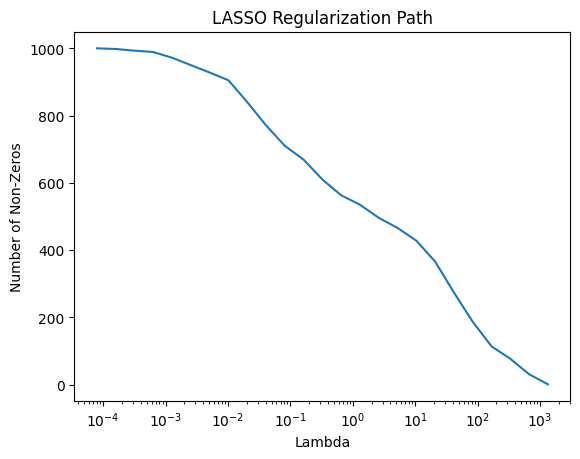

In [3]:
### Your plotting code goes here ####
def Q1a():
    lambdas = []
    non_zeross = []

    X, y = generate_data(n=500, d=1000, k=100, sigma=1)

    _lambda = get_lambda_max(X, y)
    print(f"lambda_max: {_lambda}")

    start_weight = None
    zeros = 1000
    while zeros > 0:
        weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=start_weight)
        zeros = np.sum(weight == 0)
        print(zeros)
        start_weight = weight
        
        lambdas.append(_lambda)
        non_zeross.append(1000 - zeros)
        
        _lambda /= 2

    print(f"Final lambda: {_lambda * 2}")
    plt.plot(lambdas, non_zeross)
    plt.xscale('log')
    plt.xlabel("Lambda")
    plt.ylabel("Number of Non-Zeros")
    plt.title("LASSO Regularization Path")
    plt.show()

Q1a()

**b.** [10 points] For each value of $\lambda$ tried, record values for false discovery rate (FDR) (number of incorrect
nonzeros in $\hat{w}$/total number of nonzeros in $\hat{w}$) and true positive rate (TPR) (number of correct nonzeros
in $\hat{w}/k$). Note: for each $j$, $\hat{w}_j$ is an incorrect nonzero if and only if $\hat{w}_j \neq 0$ while $w_j = 0$. In plot 2, plot these values with the x-axis as FDR, and the y-axis as TPR.
Note that in an ideal situation we would have an (FDR,TPR) pair in the upper left corner. We can always trivially achieve $(0, 0)$ and $(\frac{d−k}{d},1)$.

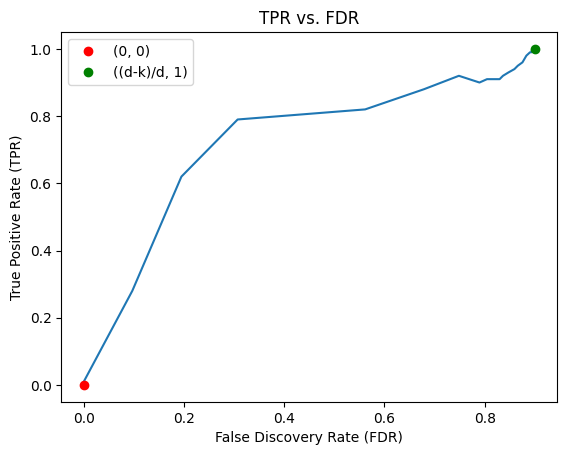

In [4]:
### Your plotting code goes here ####
def Q1b():
    np.random.seed(0)
    lambdas = []
    non_zeross = []
    fdrs = []
    tprs = []

    X, y = generate_data(n=500, d=1000, k=100, sigma=1)
    _lambda = get_lambda_max(X, y)
    start_weight = None
    zeros = 1000
    while zeros > 0:
        weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=start_weight)
        start_weight = weight

        zeros = np.sum(weight == 0)
        non_zeros = 1000 - zeros

        correct_non_zeros = np.sum(weight[:100] != 0)   # Only the first k=100 weights should be non-zero
        tpr = correct_non_zeros / 100
        tprs.append(tpr)

        incorrect_non_zeros = np.sum(weight[100:] != 0)
        if non_zeros:
            fdr = incorrect_non_zeros / non_zeros
        else:
            fdr = 0
        fdrs.append(fdr)
        
        lambdas.append(_lambda)
        non_zeross.append(non_zeros)
        
        _lambda /= 2

    plt.plot(fdrs, tprs)
    plt.plot(0, 0, 'ro', label="(0, 0)")
    plt.plot((1000-100)/1000, 1, 'go', label="((d-k)/d, 1)")
    plt.legend()
    plt.xlabel("False Discovery Rate (FDR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("TPR vs. FDR")
    plt.show()

Q1b()

**c.** [5 points] Comment on the effect of λ in these two plots in 1-2 sentences.

**What to Submit:**
- **Part a:** Plot 1.
- **Part b:** Plot 2.
- **Part c:** 1-2 sentence explanation.


## Q2 - Lasso On Real Data

We’ll now put the Lasso to work on some real data. Download the training data set ```crime-train.txt``` and the test data set ```crime-test.txt``` from the gitlab repository. Store your data in your working directory, ensure you have the pandas library for Python installed, and read in the files with:

```python
import pandas as pd
df_train = pd.read_table("crime-train.txt")
df_test = pd.read_table("crime-test.txt")
```

This stores the data as Pandas ```DataFrame``` objects. ```DataFrames``` are similar to Numpy ```arrays``` but more flexible; unlike ```arrays```, ```DataFrames``` store row and column indices along with the values of the data. Each column of a
```DataFrame``` can also store data of a different type (here, all data are floats). Here are a few commands that will
get you working with Pandas for this assignment:

```python
df.head() # Print the first few lines of DataFrame df.
df.index # Get the row indices for df.
df.columns # Get the column indices.
df[‘‘foo’’] # Return the column named ‘‘foo’’.
df.drop(‘‘foo’’, axis = 1) # Return all columns except ‘‘foo’’.
df.values # Return the values as a Numpy array.
df[‘‘foo’’].values # Grab column foo and convert to Numpy array.
df.iloc[:3,:3] # Use numerical indices (like Numpy) to get 3 rows and cols.
```

The data consist of local crime statistics for 1,994 US communities. The response $y$ is the rate of violent crimes reported per capita in a community. The name of the response variable is ```ViolentCrimesPerPop```, and it is held in the first column of ```df_train``` and ```df_test```. There are 95 features. These features include many variables. Some features are the consequence of complex political processes, such as the size of the police force and other systemic and historical factors. Others are demographic characteristics of the community, including self-reported statistics about race, age, education, and employment drawn from Census reports.

The goals of this problem are threefold: (i) to encourage you to think about how data collection processes affect the resulting model trained from that data; (ii) to encourage you to think deeply about models you might train and how they might be misused; and (iii) to see how Lasso encourages sparsity of linear models in settings where $d$ is large relative to $n$. 

**We emphasize that training a model on this dataset can suggest a degree of correlation between a community’s demographics and the rate at which a community experiences and reports violent crime. We strongly encourage students to consider why these correlations may or may not hold more generally, whether correlations might result from a common cause, and what issues can result in misinterpreting what a model can explain.**

The dataset is split into a training and test set with 1,595 and 399 entries, respectively (The features have been standardized to have mean 0 and variance 1). We will use this training set to fit a model to predict the crime rate in new communities and evaluate model performance on the test set. As there are a considerable number of input variables and fairly few training observations, overfitting is a serious issue. In order to avoid this, use the coordinate descent Lasso algorithm implemented in the previous
problem.

**a.** [4 points] Read the documentation for the original version of this dataset: [link here](http://archive.ics.uci.edu/ml/datasets/communities+and+crime). Report 3 features included in this dataset for which historical policy choices in the US would lead to variability in these features. As an example, the *number of police* in a community is often the consequence of decisions made by governing bodies, elections, and amount of tax revenue available to decision makers.

**b.** [4 points] Before you train a model, describe 3 features in the dataset which might, if found to have nonzero weight in model, be interpreted as *reasons* for higher levels of violent crime, but which might actually be a result rather than (or in addition to being) the cause of this violence.

Now, we will run the Lasso solver. Begin with $\lambda = \lambda_\mathrm{max}$ defined in Equation (1). Initialize all weights to 0. Then, reduce $\lambda$ by a factor of 2 and run again, but this time initialize $\hat{w}$ from your $\lambda = \lambda_\mathrm{max}$ solution as your initial weights, as described above. Continue the process of reducing $\lambda$ by a factor of 2 until $\lambda < 0.01$. For all plots use a log-scale for the $\lambda$ dimension (Tip: use ```plt.xscale(’log’)```).

**c.** [4 points] Plot the number of nonzero weights of each solution as a function of $\lambda$.

In [5]:
### your code here ###
import pandas as pd

df_train = pd.read_table("data/crime-data/crime-train.txt")
df_test = pd.read_table("data/crime-data/crime-test.txt")

X_train = df_train.drop("ViolentCrimesPerPop", axis=1)
y_train = df_train["ViolentCrimesPerPop"]

X_test = df_test.drop("ViolentCrimesPerPop", axis=1)
y_test = df_test["ViolentCrimesPerPop"]

lambda_max: 541.4826026332289
Final lambda: 0.016524737629187894


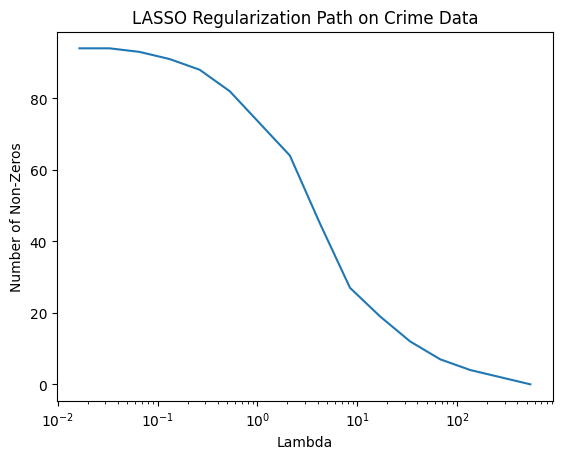

In [6]:
def Q2c(X, y):
    lambdas = []
    non_zeross = []

    d = X.shape[1]
    lambda_factor = 2

    _lambda = get_lambda_max(X, y)
    print(f"lambda_max: {_lambda}")

    start_weight = None
    while _lambda > 0.01:
        weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=start_weight)
        start_weight = weight
        
        lambdas.append(_lambda)

        zeros = np.sum(weight == 0)
        non_zeross.append(d - zeros)
        
        _lambda /= lambda_factor

    print(f"Final lambda: {_lambda * lambda_factor}")
    plt.plot(lambdas, non_zeross)
    plt.xscale('log')
    plt.xlabel("Lambda")
    plt.ylabel("Number of Non-Zeros")
    plt.title("LASSO Regularization Path on Crime Data")
    plt.show()

Q2c(X=X_train.values, y=y_train.values)

**d.** [4 points] Plot the regularization paths (in one plot) for the coefficients for input variables ```agePct12t29```,
```pctWSocSec```, ```pctUrban```, ```agePct65up```, and ```householdsize```.

lambda_max: 541.4826026332289
Final lambda: 0.016524737629187894


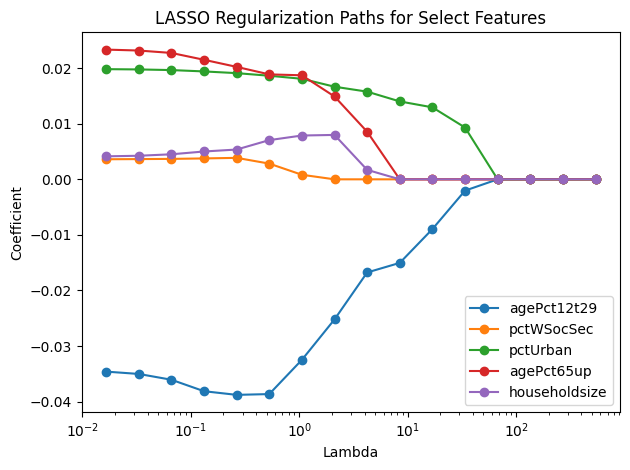

In [7]:
### your code here ###
def Q2d():
    X = X_train.values
    y = y_train.values

    # Get the column indices for the features
    features = ['agePct12t29', 'pctWSocSec', 'pctUrban', 'agePct65up', 'householdsize']
    feature_indices = []
    all_columns = list(X_train.columns)
    for feature in features:
        feature_indices.append(all_columns.index(feature))

    lambdas = []
    coefficients = {feature: [] for feature in features}

    d = X.shape[1]
    lambda_factor = 2

    _lambda = get_lambda_max(X, y)
    print(f"lambda_max: {_lambda}")

    start_weight = None
    while _lambda >= 0.01:
        weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=start_weight)
        start_weight = weight
        
        lambdas.append(_lambda)
        _lambda /= lambda_factor

        for i, feature in enumerate(features):
            coefficients[feature].append(weight[feature_indices[i]])

    print(f"Final lambda: {_lambda * lambda_factor}")

    plt.figure()
    for feature in features:
        plt.plot(lambdas, coefficients[feature], marker='o', label=feature)
    plt.xscale('log')
    plt.xlabel("Lambda")
    plt.ylabel("Coefficient")
    plt.title("LASSO Regularization Paths for Select Features")
    plt.legend()
    plt.tight_layout()
    plt.show()

Q2d()

**e.** [4 points] On one plot, plot the squared error on the training and test data as a function of $\lambda$.

lambda_max: 541.4826026332289


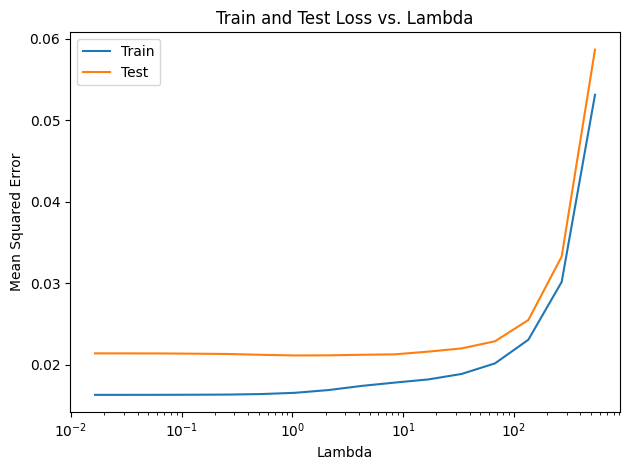

In [8]:
### your code here ###
def get_mse(X, y, weight, b):
    pred = X @ weight + b
    mse = np.mean((pred - y)**2)
    return mse

def Q2e(X, y):
    lambdas = []
    train_losses = []
    test_losses = []

    d = X.shape[1]
    lambda_factor = 2

    _lambda = get_lambda_max(X, y)
    print(f"lambda_max: {_lambda}")

    start_weight = None
    while _lambda >= 0.01:
        weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=start_weight)
        start_weight = weight
        
        lambdas.append(_lambda)
        train_losses.append(get_mse(X=X_train.values, y=y_train.values, weight=weight, b=b))
        test_losses.append(get_mse(X=X_test.values, y=y_test.values, weight=weight, b=b))
        
        _lambda /= lambda_factor

    plt.figure()
    plt.plot(lambdas, train_losses, label="Train")
    plt.plot(lambdas, test_losses, label="Test")
    plt.xscale('log')
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error")
    plt.title("Train and Test Loss vs. Lambda")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
Q2e(X=X_train.values, y=y_train.values)

**f.** [4 points] Sometimes a larger value of $\lambda$ performs nearly as well as a smaller value, but a larger value will select fewer variables and perhaps be more interpretable. Inspect the weights $\hat{w}$ for $\lambda = 30$. Which feature had the largest (most positive) Lasso coefficient? What about the most negative? Discuss briefly.

**g.** [4 points] Suppose there was a large negative weight on ```agePct65up``` and upon seeing this result, a politician suggests policies that encourage people over the age of 65 to move to high crime areas in an effort to reduce crime. What is the (statistical) flaw in this line of reasoning? (Hint: fire trucks are often seen around burning buildings, do fire trucks cause fire?)

**What to Submit:**
- **Parts a, b:** 1-2 sentence explanation.
- **Part c:** Plot 1.
- **Part d:** Plot 2.
- **Part e:** Plot 3.
- **Parts f, g:** Answers and 1-2 sentence explanation.


In [9]:
def Q2f(X, y):
    _lambda = 30
    weight, b = train(X, y, _lambda, convergence_delta=0.0001, start_weight=None)
    
    # Find the feature with the most positive coefficient
    max_idx = np.argmax(weight)
    max_feature = X_train.columns[max_idx]
    print(max_feature, weight[max_idx])

    # Feature with the most negative coefficient
    min_idx = np.argmin(weight)
    min_feature = X_train.columns[min_idx]
    print(min_feature, weight[min_idx])
    
Q2f(X=X_train.values, y=y_train.values)

PctIlleg 0.0687252852968382
PctKids2Par -0.06921580730627476
